# Figure 7: Effect of Connectivity on Inductive Bias

This notebook (by changing some of the important parameters below) can be used to generate the panels in figure 7 from 'Meta-Learning Inductive Biases of Simple Neural Circuits', Dorrell et al. 2022.

It shows the way various connectivity patterns effect the inductive bias in a network trained end-to-end by gradient descent.

In [1]:
# Import Things
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from geomloss import SamplesLoss  # See also ImagesLoss, VolumesLoss

In [2]:
# Function that lets us update the pytorch parameters in place, while still allowing gradients to flow through these updates
def update_module(module, updates=None, memo=None):
    r"""
    [[Source]](https://github.com/learnables/learn2learn/blob/master/learn2learn/utils.py)
    **Description**
    Updates the parameters of a module in-place, in a way that preserves differentiability.
    The parameters of the module are swapped with their update values, according to:
    \[
    p \gets p + u,
    \]
    where \(p\) is the parameter, and \(u\) is its corresponding update.
    **Arguments**
    * **module** (Module) - The module to update.
    * **updates** (list, *optional*, default=None) - A list of gradients for each parameter
        of the model. If None, will use the tensors in .update attributes.
    **Example**
    ~~~python
    error = loss(model(X), y)
    grads = torch.autograd.grad(
        error,
        model.parameters(),
        create_graph=True,
    )
    updates = [-lr * g for g in grads]
    l2l.update_module(model, updates=updates)
    ~~~
    """
    if memo is None:
        memo = {}
    if updates is not None:
        params = list(module.parameters())
        if not len(updates) == len(list(params)):
            msg = 'WARNING:update_module(): Parameters and updates have different length. ('
            msg += str(len(params)) + ' vs ' + str(len(updates)) + ')'
            print(msg)
        for p, g in zip(params, updates):
            p.update = g

    # Update the params
    for param_key in module._parameters:
        p = module._parameters[param_key]
        if p is not None and hasattr(p, 'update') and p.update is not None:
            if p in memo:
                module._parameters[param_key] = memo[p]
            else:
                updated = p + p.update
                memo[p] = updated
                module._parameters[param_key] = updated

    # Second, handle the buffers if necessary
    for buffer_key in module._buffers:
        buff = module._buffers[buffer_key]
        if buff is not None and hasattr(buff, 'update') and buff.update is not None:
            if buff in memo:
                module._buffers[buffer_key] = memo[buff]
            else:
                updated = buff + buff.update
                memo[buff] = updated
                module._buffers[buffer_key] = updated

    # Then, recurse for each submodule
    for module_key in module._modules:
        module._modules[module_key] = update_module(
            module._modules[module_key],
            updates=None,
            memo=memo,
        )

    # Finally, rebuild the flattened parameters for RNNs
    # See this issue for more details:
    # https://github.com/learnables/learn2learn/issues/139
    if hasattr(module, 'flatten_parameters'):
        module._apply(lambda x: x)
    return module

In [3]:
def Train_Test_Learner(learner, x_tr, z_tr, learner_params, x_test):
    optimizer = torch.optim.Adam(learner.parameters(), lr = 0.01)
    rand_sparse = learner_params["rand_sparse"]
    
    for i in range(learner_params["t"]):
        optimizer.zero_grad()
        train_index = np.random.choice(learner_params["m"], learner_params["m_here"])
        
        z_l = learner(x_tr[train_index,:])
        
        loss = torch.mean((z_tr[train_index,:] - z_l)**2)
        g = torch.autograd.grad(loss, learner.parameters(), create_graph=True)
        updates = list(map(lambda x: -learner_params["eta"]*x, g))
        
        with torch.no_grad():
            for index in range(learner_params["K"]):
                for sparse_ind in range(input_size_gen - learner_params["sparsity"]):
                    updates[0][index, learner_params["rand_sparse"][index, sparse_ind]] = 0            
                
        learner = update_module(learner, updates)
        
        with torch.no_grad():
            if learner_params["positivity"] == 1:
                for index in range(learner_params["K"]):
                    learner[0].weight[index, :] = torch.abs(learner[0].weight[index, :])

    return learner(x_test)

def generate_sparsifier(learner_params):
    if "p" in learner_params:
        sparsifier = np.array([np.delete(np.arange(0, input_size_gen), np.random.choice(input_size_gen, learner_params["sparsity"],  p=learner_params["p"], replace=False)) for i in range(learner_params["K"])])
    elif "p1" in learner_params:
        connected = np.zeros([learner_params["K"], learner_params["sparsity"]])
        sparsifier = np.zeros([learner_params["K"], input_size_gen - learner_params["sparsity"]])
        for neuron in range(learner_params["K"]):
            connected[neuron, 0] = np.random.choice(input_size_gen, 1, p = learner_params["p1"])
            if connected[neuron, 0] < 2:
                connected[neuron, 1] = np.random.choice(np.delete(np.arange(0, input_size_gen), int(connected[neuron, 0])), 1, p = learner_params["p2G"])
            else:
                connected[neuron, 1] = np.random.choice(np.delete(np.arange(0, input_size_gen), int(connected[neuron, 0])), 1, p = learner_params["p2N"])
        sparsifier = np.array([np.delete(np.arange(0, input_size_gen), connected[neuron, :].astype(int)) for neuron in range(learner_params["K"])])
    else:
        sparsifier = np.array([np.delete(np.arange(0, input_size_gen), np.random.choice(input_size_gen, learner_params["sparsity"], replace=False)) for i in range(learner_params["K"])])
    return sparsifier

In [4]:
def Sparse_Plotter(M_plot, input_size_gen, network, title = None):
    # Let's have a look at a lot of datapoints then
    x_plot = generate_data(M_plot,input_size_gen)
    z_plot = network(x_plot).detach().numpy()

    plt.figure(figsize = (20, 4))
    for ind in range(input_size_gen):
        plt.subplot(1, input_size_gen, ind+1)
        plt.scatter(x_plot[:,ind], z_plot)
        frame = plt.gca()
        frame.axes.get_xaxis().set_visible(False)
        frame.axes.get_yaxis().set_visible(False)

    if title != None:
        plt.savefig(f"{title}_1D.svg")

        
    # Can we get any insight?
    plt.figure(figsize = (12, 12))
    for ind_1 in range(input_size_gen):
        for ind_2 in range(ind_1):
            plt.subplot(input_size_gen, input_size_gen, ind_1*input_size_gen + 1 + ind_2)
            plt.scatter(x_plot[:,ind_1], x_plot[:,ind_2], c = z_plot)
            frame = plt.gca()
            frame.axes.get_xaxis().set_visible(False)
            frame.axes.get_yaxis().set_visible(False)
            
    if title != None:
        plt.savefig(f"{title}_2D.svg")  
        
    if input_size_gen == 3:
        x_plot_2 = threeto2D(x_plot)
        fig = plt.figure(figsize = (6, 6))
        plt.scatter(x_plot_2[:,0], x_plot_2[:,1], c = z_plot)

In [5]:
def generate_data(N, D):
    x = torch.normal(0, 1, [N, D])
    x = x/torch.norm(x, dim = 1)[:,np.newaxis]
    return x

# Function to map points on sphere to 2D
def threeto2D(x):
    y = np.zeros([x.shape[0], 2])
    y[:,0] = np.arctan2(x[:,1],x[:,0])+torch.pi
    y[:,1] = np.arctan2(x[:,2],np.sqrt(np.power(x[:,0],2) + np.power(x[:,1],2)))+torch.pi/2
    return y

def generate_target_distr(M, learner_params):
    #if learner_params["positivity"] == 0:
    #    return 2 * torch.rand(M, 1) - 1
    #else:
    return 2*torch.rand(M, 1)-1

This cell does the learning of the easiest to generalise function, and sets the learner's parameters for the whole notebook.

We used: K = 100, sparsity = 2, input_size_gen = 2, t = 50, m = 50, m_here = 30, eta = 0.05

Then we varied the last two connectivity parameters as follows:

1. Panel B part 1: connectivity_scheme = 0, positivity = 0
2. Panel B part 2: connectivity_scheme = 1, positivity = 0
3. Panel E: connectivity_scheme = 2, positivity = 0
4. Panel F: connectivity_scheme = 2, positivity = 1

In [22]:
# Meta-learner parameterse
input_size_gen = 5 # Input dimensionality
hidden_size_gen = 150
output_size_gen = 1

# Learner parameters
learner_params = {"K": 100, # Hidden layer size
                  "sparsity": 2, # Number of connections per hidden layer neuron
                  "t": 50, # Inner loop training steps
                  "m": 50, # Number of datapoints in training set
                  "m_here": 30, # Number to use in each loop
                  "eta": 0.05, # Learning rate of the network
                 "positivity": 0, # Should all the first layer connection weights be positive?
                  "connectivity_scheme": 0} # Connectivity scheme, 0 for random 2-sparse, 1 for over-connected, 2 for grouped. 
# Connectivity schemes 1 and 2 are only coded up for 4 or 5 input neurons.
if learner_params["connectivity_scheme"] == 1:
    if input_size_gen == 5:
        learner_params["p"] = [0.6, 0.1, 0.1, 0.1, 0.1]
    elif input_size_gen == 4:
        learner_params["p"] = [0.7, 0.1, 0.1, 0.1]
elif learner_params["connectivity_scheme"] == 2:
    if input_size_gen == 5:
        learner_params["p1"] = [0.2, 0.2, 0.2, 0.2, 0.2]
        learner_params["p2G"] = [0.85, 0.05, 0.05, 0.05]
        learner_params["p2N"] = [0.1, 0.1, 0.4, 0.4]
    elif input_size_gen == 4:
        learner_params["p1"] = [0.25, 0.25, 0.25, 0.25]
        learner_params["p2G"] = [0.45, 0.45, 0.1]
        learner_params["p2N"] = [0.33, 0.33, 0.34]
# Set up meta-learner and training procedure
meta_learner =  torch.nn.Sequential(torch.nn.Linear(input_size_gen, hidden_size_gen, bias=True),
                               torch.nn.ReLU(),
                                torch.nn.Linear(hidden_size_gen, hidden_size_gen, bias=True),
                               torch.nn.ReLU(),
                                torch.nn.Linear(hidden_size_gen, output_size_gen, bias=True))
meta_optimizer = torch.optim.Adam(meta_learner.parameters(), lr = 0.0025)
T = 200 # Number of meta steps
M = 300 # Test points per meta step

# Some admin
min_loss = 1000000
loss_entropy = SamplesLoss(loss="sinkhorn", p=2, blur=.05) 

for meta_step in range(T):
    meta_optimizer.zero_grad()
    
    # Set up new learner
    #rand_sparse = np.random.choice(3, K)
    learner_params["rand_sparse"] = generate_sparsifier(learner_params)
    learner = torch.nn.Sequential(torch.nn.Linear(input_size_gen, learner_params["K"], bias=True),
                               torch.nn.ReLU(),
                               torch.nn.Linear(learner_params["K"], output_size_gen, bias=True))
    with torch.no_grad():
        for index in range(learner_params["K"]):
            for sparse_ind in range(input_size_gen - learner_params["sparsity"]):
                learner[0].weight[index,learner_params["rand_sparse"][index, sparse_ind]] = 0 
            if learner_params["positivity"] == 1:
                learner[0].weight[index, :] = torch.abs(learner[0].weight[index, :])
                  
    # Generate training data and labels
    x = generate_data(learner_params["m"],input_size_gen)
    z = meta_learner(x)
    
    # And test set and labels
    x_test = generate_data(M,input_size_gen)
    z_test = meta_learner(x_test)
    
    # Now train and test learner
    z_test_l = Train_Test_Learner(learner, x, z, learner_params, x_test)

    # Measure generalisation error and distribution loss
    distr = generate_target_distr(M, learner_params)
    z_test_l = learner(x_test)
    meta_loss = 1000*torch.mean((z_test - z_test_l)**2) + 500*loss_entropy(z_test, distr)
    meta_loss.backward()
    meta_optimizer.step()

        #print(learner[0].weight)
    if meta_loss < min_loss:
        meta_learner_best = meta_learner
        min_loss = meta_loss
    
    if meta_step % 5 == 0:
        # print(learner[0].weight)
        print(f"Meta-Step: {meta_step}/{T}, Meta-Loss: {meta_loss:0.2f}, Loss_g: {torch.mean((z_test - z_test_l)**2):0.4f}")    
        

Meta-Step: 0/200, Meta-Loss: 72.60, Loss_g: 0.0008
Meta-Step: 5/200, Meta-Loss: 17.99, Loss_g: 0.0116
Meta-Step: 10/200, Meta-Loss: 50.07, Loss_g: 0.0499
Meta-Step: 15/200, Meta-Loss: 16.73, Loss_g: 0.0133
Meta-Step: 20/200, Meta-Loss: 20.85, Loss_g: 0.0145
Meta-Step: 25/200, Meta-Loss: 36.74, Loss_g: 0.0253
Meta-Step: 30/200, Meta-Loss: 43.27, Loss_g: 0.0331
Meta-Step: 35/200, Meta-Loss: 52.14, Loss_g: 0.0402
Meta-Step: 40/200, Meta-Loss: 29.27, Loss_g: 0.0161
Meta-Step: 45/200, Meta-Loss: 31.00, Loss_g: 0.0187
Meta-Step: 50/200, Meta-Loss: 35.55, Loss_g: 0.0292
Meta-Step: 55/200, Meta-Loss: 29.77, Loss_g: 0.0135
Meta-Step: 60/200, Meta-Loss: 30.87, Loss_g: 0.0059
Meta-Step: 65/200, Meta-Loss: 43.98, Loss_g: 0.0342
Meta-Step: 70/200, Meta-Loss: 31.28, Loss_g: 0.0218
Meta-Step: 75/200, Meta-Loss: 27.79, Loss_g: 0.0156
Meta-Step: 80/200, Meta-Loss: 21.83, Loss_g: 0.0103
Meta-Step: 85/200, Meta-Loss: 36.07, Loss_g: 0.0244
Meta-Step: 90/200, Meta-Loss: 42.31, Loss_g: 0.0352
Meta-Step: 95/

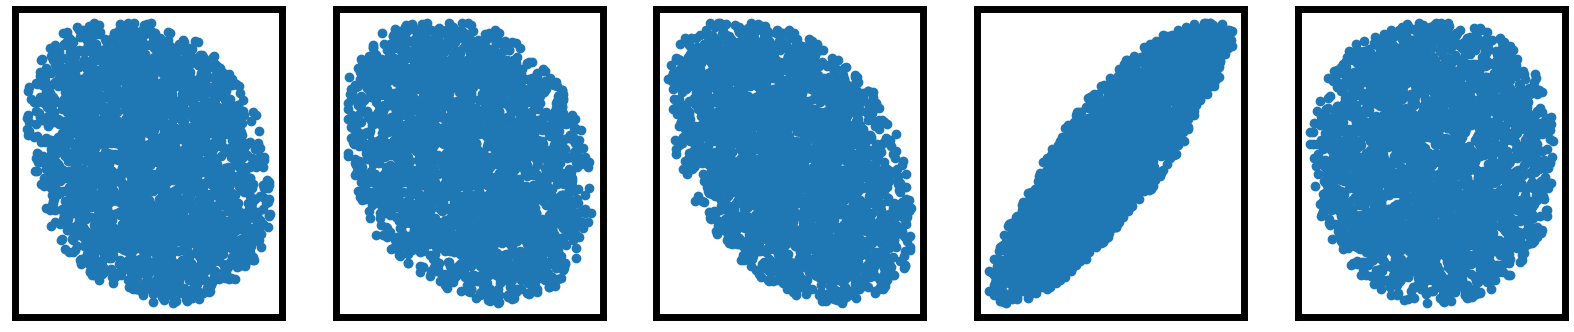

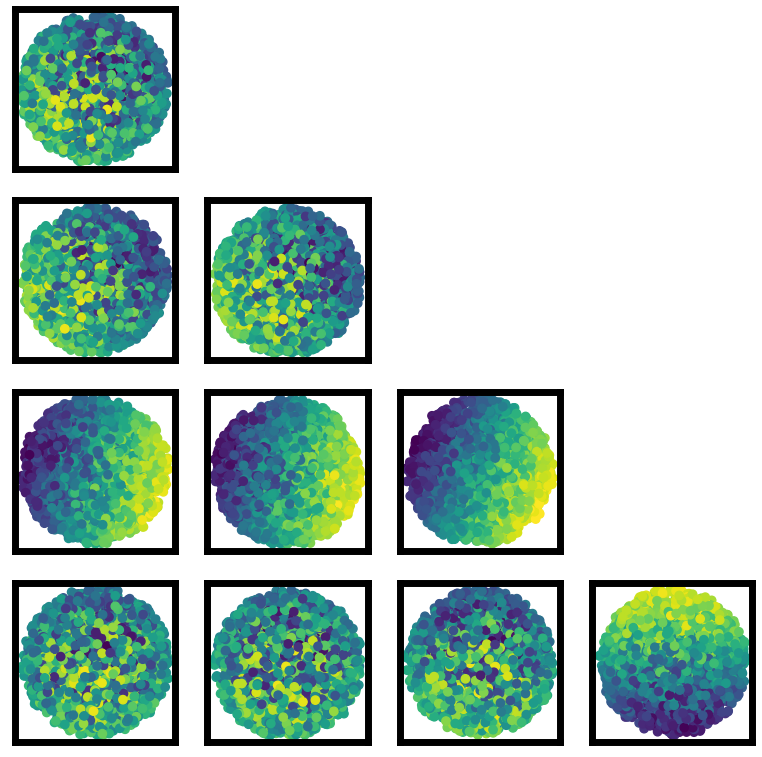

In [23]:
# Let's have a look at a lot of datapoints then
M_plot = 3000
network = meta_learner_best
x_plot = generate_data(M_plot,input_size_gen)
z_plot = network(x_plot).detach().numpy()
plt.rcParams['axes.linewidth'] = 5 #set the value globally


plt.figure(figsize = (20, 4))
for ind in range(input_size_gen):
    plt.subplot(1, input_size_gen, ind+1)
    plt.scatter(x_plot[:,ind], z_plot)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

plt.savefig("SparsityA.svg")
# Can we get any insight?
plt.figure(figsize = (12, 12))
for ind_1 in range(input_size_gen):
    for ind_2 in range(ind_1):
        plt.subplot(input_size_gen, input_size_gen, ind_1*input_size_gen + 1 + ind_2)
        plt.scatter(x_plot[:,ind_1], x_plot[:,ind_2], c = z_plot)
        frame = plt.gca()
        frame.axes.get_xaxis().set_visible(False)
        frame.axes.get_yaxis().set_visible(False)

if input_size_gen == 3:
    x_plot_2 = threeto2D(x_plot)
    fig = plt.figure(figsize = (6, 6))
    plt.scatter(x_plot_2[:,0], x_plot_2[:,1], c = z_plot)

In [24]:
# Is it just doing linear labelling, along which axes if so?
x_plot = generate_data(M_plot,input_size_gen)
z_plot = meta_learner_best(x_plot).detach().numpy()
x_plot = np.hstack([x_plot.detach().numpy(), np.ones([M_plot, 1])])

w = np.matmul(np.linalg.inv(np.matmul(np.transpose(x_plot), x_plot) + 0.01*np.eye(input_size_gen+1)),np.matmul(np.transpose(x_plot), z_plot))

z_hat = np.matmul(x_plot, w)
l_fit = np.sum((z_hat - z_plot)**2)/M_plot
print(l_fit)
print(w)

0.00034732355934290914
[[-0.17594719]
 [-0.1855691 ]
 [-0.31868344]
 [ 0.67125271]
 [-0.0092164 ]
 [ 0.00634417]]


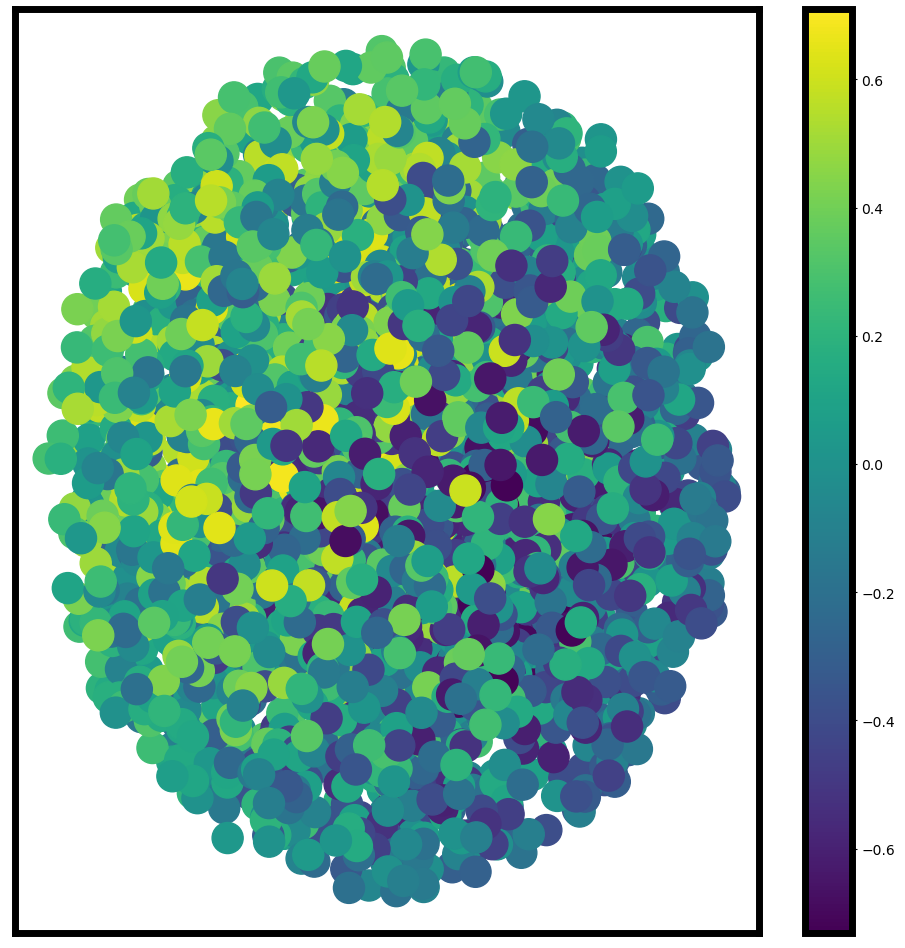

In [25]:
# Use this cell to get the plot we used for panel F.
w1 = np.array([1,1,0,0,0,0])
w2 = np.array([0,0,1,1,1,0])

proj_1 = np.matmul(x_plot, w1)
proj_2 = np.matmul(x_plot, w2)
plt.figure(figsize = (12,12))
plt.scatter(proj_1, proj_2, c = z_plot, s = 500)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
plt.colorbar()
plt.savefig("Projected_Avg_Group_Act.svg")


# Now can we do the orthogonal things

Use this series of plots to get 5 orthogonal functions

In [26]:
# Data against which we'll measure orthogonality
M_orth = 1000
x_orth = generate_data(M_orth, input_size_gen)
z1 = meta_learner_best(x_orth).detach()

In [27]:
# Set up meta-learner and training procedure
meta_learner =  torch.nn.Sequential(torch.nn.Linear(input_size_gen, hidden_size_gen, bias=True),
                               torch.nn.ReLU(),
                                torch.nn.Linear(hidden_size_gen, hidden_size_gen, bias=True),
                               torch.nn.ReLU(),
                               torch.nn.Linear(hidden_size_gen, output_size_gen, bias=True))
meta_optimizer = torch.optim.Adam(meta_learner.parameters(), lr = 0.01)
T = 200 # Number of meta steps
M = 150 # Test points per meta step

# Some admin
min_loss = 1000000

for meta_step in range(T):
    meta_optimizer.zero_grad()
    
    # Set up new learner
    learner_params["rand_sparse"] = generate_sparsifier(learner_params)
    learner = torch.nn.Sequential(torch.nn.Linear(input_size_gen, learner_params["K"], bias=True),
                               torch.nn.ReLU(),
                               torch.nn.Linear(learner_params["K"], output_size_gen, bias=True))
    with torch.no_grad():
        for index in range(learner_params["K"]):
            for sparse_ind in range(learner_params["sparsity"]):
                learner[0].weight[index,learner_params["rand_sparse"][index, sparse_ind]] = 0
    #print(learner[0].weight)
    
    # Generate training data and labels
    x = generate_data(learner_params["m"],input_size_gen)
    z = meta_learner(x)
    
    # And test set and labels
    x_test = generate_data(M,input_size_gen)
    z_test = meta_learner(x_test)
    
    # Now train and test learner
    z_test_l = Train_Test_Learner(learner, x, z, learner_params, x_test)
    
    # Measure generalisation error and distribution loss
    z_orth = meta_learner(x_orth)
    distr = generate_target_distr(M, learner_params)
    z_test_l = learner(x_test)
    l_orth_1 =  torch.sum(torch.multiply(z_orth, z1))**2
    meta_loss = 1000*torch.mean((z_test - z_test_l)**2) + 1000*loss_entropy(z_test, distr) + l_orth_1
    meta_loss.backward()
    meta_optimizer.step()

        #print(learner[0].weight)
    if meta_loss < min_loss:
        meta_learner_best_2 = meta_learner
        min_loss = meta_loss
    
    if meta_step % 5 == 0:
        print(f"Meta-Step: {meta_step}/{T}, Meta-Loss: {meta_loss:0.2f}, Loss_g: {torch.mean((z_test - z_test_l)**2):0.4f}, Loss_O: {l_orth_1:0.4f}")    
        

Meta-Step: 0/200, Meta-Loss: 174.66, Loss_g: 0.0009, Loss_O: 19.0622
Meta-Step: 5/200, Meta-Loss: 319.60, Loss_g: 0.0007, Loss_O: 197.2850
Meta-Step: 10/200, Meta-Loss: 208.70, Loss_g: 0.0010, Loss_O: 72.6186
Meta-Step: 15/200, Meta-Loss: 175.28, Loss_g: 0.0006, Loss_O: 6.5876
Meta-Step: 20/200, Meta-Loss: 158.15, Loss_g: 0.0008, Loss_O: 6.7130
Meta-Step: 25/200, Meta-Loss: 154.96, Loss_g: 0.0009, Loss_O: 2.6801
Meta-Step: 30/200, Meta-Loss: 147.74, Loss_g: 0.0011, Loss_O: 0.9671
Meta-Step: 35/200, Meta-Loss: 104.11, Loss_g: 0.0032, Loss_O: 3.2782
Meta-Step: 40/200, Meta-Loss: 78.61, Loss_g: 0.0046, Loss_O: 1.8998
Meta-Step: 45/200, Meta-Loss: 27.24, Loss_g: 0.0102, Loss_O: 0.0043
Meta-Step: 50/200, Meta-Loss: 67.08, Loss_g: 0.0655, Loss_O: 0.4140
Meta-Step: 55/200, Meta-Loss: 54.06, Loss_g: 0.0426, Loss_O: 0.6830
Meta-Step: 60/200, Meta-Loss: 20.69, Loss_g: 0.0162, Loss_O: 0.2633
Meta-Step: 65/200, Meta-Loss: 20.64, Loss_g: 0.0192, Loss_O: 0.0304
Meta-Step: 70/200, Meta-Loss: 38.14, L

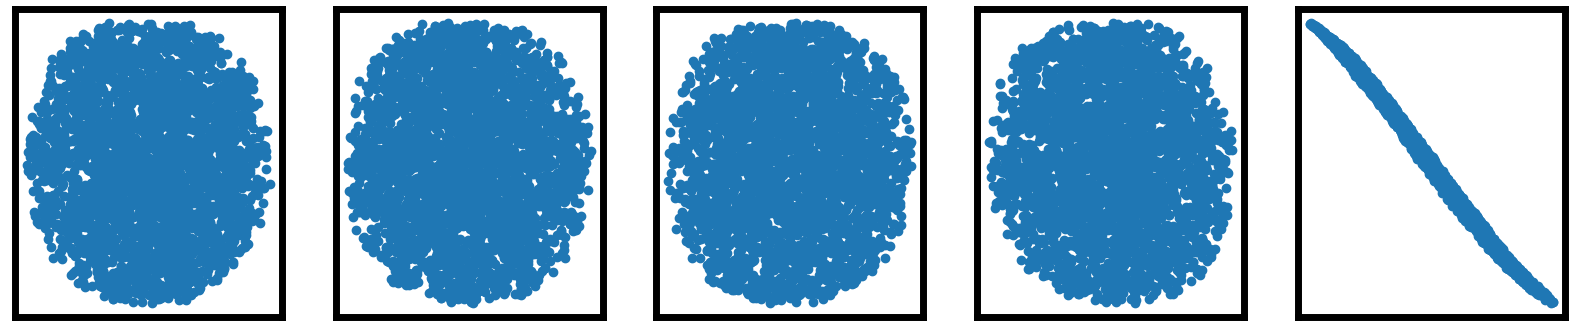

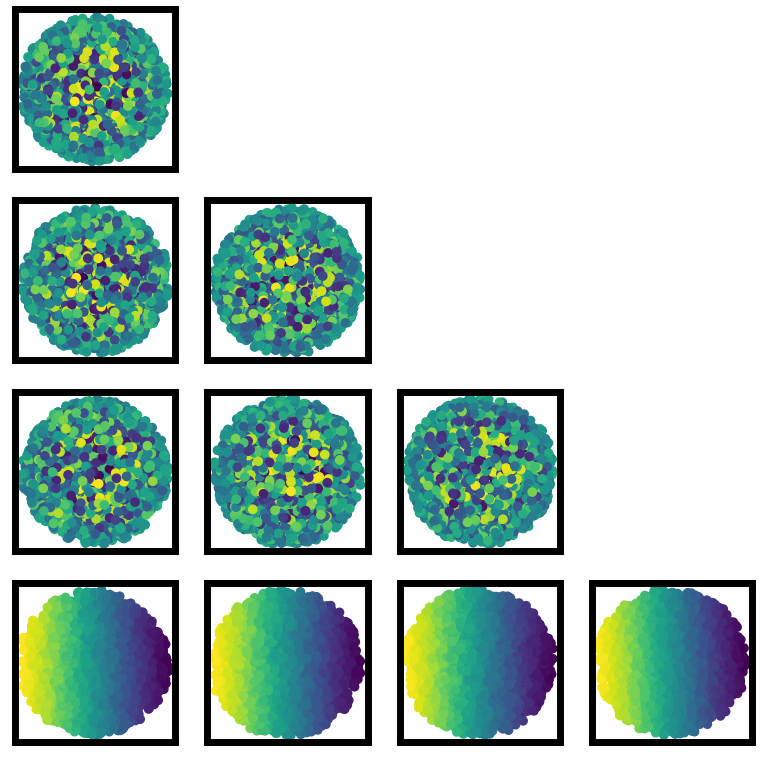

In [28]:
Sparse_Plotter(3000, input_size_gen, meta_learner_best_2, "sparsity2")

In [29]:
# Data against which we'll measure orthogonality
z2 = meta_learner_best_2(x_orth).detach()

In [30]:
# Set up meta-learner and training procedure
meta_learner =  torch.nn.Sequential(torch.nn.Linear(input_size_gen, hidden_size_gen, bias=True),
                               torch.nn.ReLU(),
                                torch.nn.Linear(hidden_size_gen, hidden_size_gen, bias=True),
                               torch.nn.ReLU(),
                               torch.nn.Linear(hidden_size_gen, output_size_gen, bias=True))
meta_optimizer = torch.optim.Adam(meta_learner.parameters(), lr = 0.01)
T = 200 # Number of meta steps
M = 150 # Test points per meta step

# Some admin
min_loss = 1000000

for meta_step in range(T):
    meta_optimizer.zero_grad()
    
    # Set up new learner
    #rand_sparse = np.random.choice(3, K)
    learner_params["rand_sparse"] = generate_sparsifier(learner_params)
    learner = torch.nn.Sequential(torch.nn.Linear(input_size_gen, learner_params["K"], bias=True),
                               torch.nn.ReLU(),
                               torch.nn.Linear(learner_params["K"], output_size_gen, bias=True))
    with torch.no_grad():
        for index in range(learner_params["K"]):
            for sparse_ind in range(learner_params["sparsity"]):
                learner[0].weight[index,learner_params["rand_sparse"][index, sparse_ind]] = 0    
    #print(learner[0].weight)
    
    # Generate training data and labels
    x = generate_data(learner_params["m"],input_size_gen)
    z = meta_learner(x)
    
    # And test set and labels
    x_test = generate_data(M,input_size_gen)
    z_test = meta_learner(x_test)
    
    # Now train and test learner
    z_test_l = Train_Test_Learner(learner, x, z, learner_params, x_test)
    
    # Measure generalisation error and distribution loss
    z_orth = meta_learner(x_orth)
    distr = generate_target_distr(M, learner_params)
    z_test_l = learner(x_test)
    l_orth_1 = torch.sum(torch.multiply(z_orth, z1))**2
    l_orth_2 = torch.sum(torch.multiply(z_orth, z2))**2
    meta_loss = 1000*torch.mean((z_test - z_test_l)**2) + 10000*loss_entropy(z_test, distr) + l_orth_1 + l_orth_2
    meta_loss.backward()
    meta_optimizer.step()

        #print(learner[0].weight)
    if meta_loss < min_loss:
        meta_learner_best_3 = meta_learner
        min_loss = meta_loss
    
    if meta_step % 5 == 0:
        print(f"Meta-Step: {meta_step}/{T}, Meta-Loss: {meta_loss:0.2f}, Loss_g: {torch.mean((z_test - z_test_l)**2):0.4f}, Loss_O: {l_orth_1:0.4f}, {l_orth_2:0.4f}")    
        

Meta-Step: 0/200, Meta-Loss: 1553.63, Loss_g: 0.0010, Loss_O: 8.1272, 4.5465
Meta-Step: 5/200, Meta-Loss: 1900.73, Loss_g: 0.0084, Loss_O: 0.8261, 1193.9265
Meta-Step: 10/200, Meta-Loss: 1375.18, Loss_g: 0.0019, Loss_O: 58.5196, 179.2522
Meta-Step: 15/200, Meta-Loss: 701.91, Loss_g: 0.0144, Loss_O: 0.5279, 17.4027
Meta-Step: 20/200, Meta-Loss: 130.94, Loss_g: 0.0401, Loss_O: 6.4921, 0.2659
Meta-Step: 25/200, Meta-Loss: 306.14, Loss_g: 0.0293, Loss_O: 0.8749, 10.8394
Meta-Step: 30/200, Meta-Loss: 196.18, Loss_g: 0.0283, Loss_O: 1.5972, 8.5835
Meta-Step: 35/200, Meta-Loss: 46.09, Loss_g: 0.0176, Loss_O: 0.6669, 3.5140
Meta-Step: 40/200, Meta-Loss: 137.59, Loss_g: 0.0228, Loss_O: 0.3207, 0.8296
Meta-Step: 45/200, Meta-Loss: 156.24, Loss_g: 0.0536, Loss_O: 0.6897, 0.1280
Meta-Step: 50/200, Meta-Loss: 223.48, Loss_g: 0.0623, Loss_O: 0.1459, 0.0242
Meta-Step: 55/200, Meta-Loss: 79.04, Loss_g: 0.0708, Loss_O: 0.0123, 0.0375
Meta-Step: 60/200, Meta-Loss: 106.66, Loss_g: 0.0397, Loss_O: 0.1866,

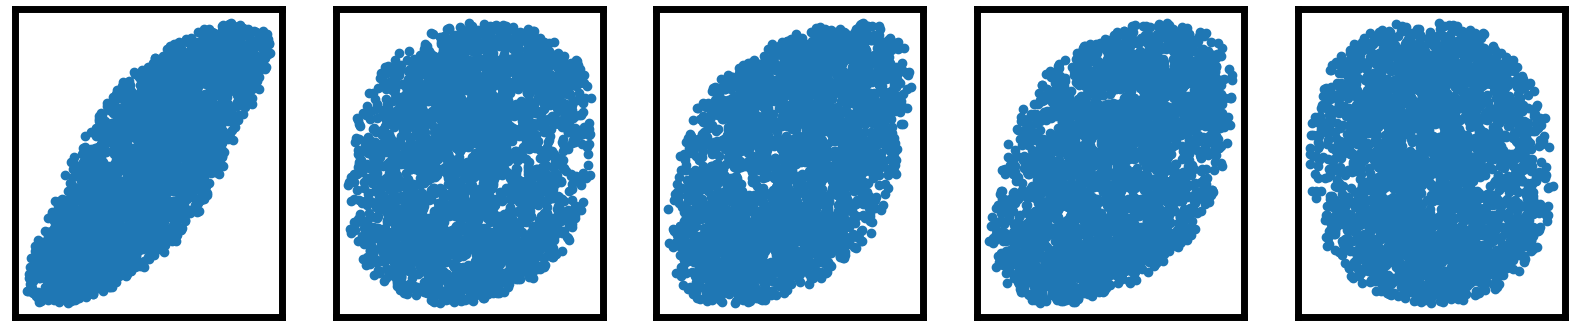

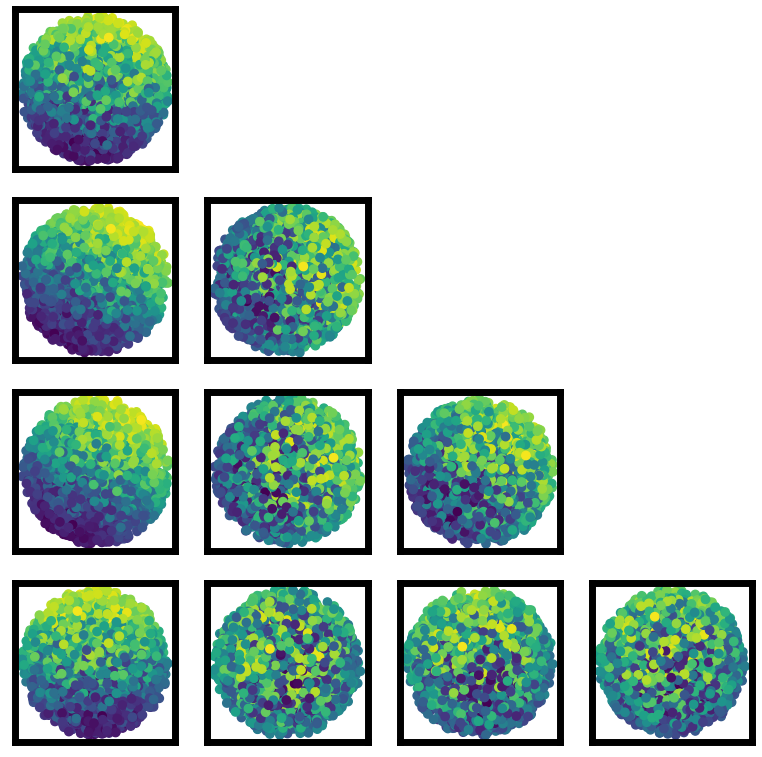

In [31]:
Sparse_Plotter(3000, input_size_gen, meta_learner_best_3, "sparsity3")

In [32]:
# Data against which we'll measure orthogonality
z3 = meta_learner_best_3(x_orth).detach()

In [33]:
# Set up meta-learner and training procedure
meta_learner =  torch.nn.Sequential(torch.nn.Linear(input_size_gen, hidden_size_gen, bias=True),
                               torch.nn.ReLU(),
                                torch.nn.Linear(hidden_size_gen, hidden_size_gen, bias=True),
                               torch.nn.ReLU(),
                               torch.nn.Linear(hidden_size_gen, output_size_gen, bias=True))
meta_optimizer = torch.optim.Adam(meta_learner.parameters(), lr = 0.01)
T = 200 # Number of meta steps
M = 150 # Test points per meta step

# Some admin
min_loss = 1000000

for meta_step in range(T):
    meta_optimizer.zero_grad()
    
    # Set up new learner
    #rand_sparse = np.random.choice(3, K)
    learner_params["rand_sparse"] = generate_sparsifier(learner_params)
    learner = torch.nn.Sequential(torch.nn.Linear(input_size_gen, learner_params["K"], bias=True),
                               torch.nn.ReLU(),
                               torch.nn.Linear(learner_params["K"], output_size_gen, bias=True))
    with torch.no_grad():
        for index in range(learner_params["K"]):
            for sparse_ind in range(learner_params["sparsity"]):
                learner[0].weight[index,learner_params["rand_sparse"][index, sparse_ind]] = 0    
    #print(learner[0].weight)
    
    # Generate training data and labels
    x = generate_data(learner_params["m"],input_size_gen)
    z = meta_learner(x)
    
    # And test set and labels
    x_test = generate_data(M,input_size_gen)
    z_test = meta_learner(x_test)
    
    # Now train and test learner
    z_test_l = Train_Test_Learner(learner, x, z, learner_params, x_test)
    
    # Measure generalisation error and distribution loss
    z_orth = meta_learner(x_orth)
    distr = generate_target_distr(M, learner_params)
    z_test_l = learner(x_test)
    l_orth_1 = torch.sum(torch.multiply(z_orth, z1))**2
    l_orth_2 = torch.sum(torch.multiply(z_orth, z2))**2
    l_orth_3 = torch.sum(torch.multiply(z_orth, z3))**2
    meta_loss = 1000*torch.mean((z_test - z_test_l)**2) + 10000*loss_entropy(z_test, distr) + l_orth_1 + l_orth_2 + l_orth_3
    meta_loss.backward()
    meta_optimizer.step()

        #print(learner[0].weight)
    if meta_loss < min_loss:
        meta_learner_best_4 = meta_learner
        min_loss = meta_loss
    
    if meta_step % 5 == 0:
        print(f"Meta-Step: {meta_step}/{T}, Meta-Loss: {meta_loss:0.2f}, Loss_g: {torch.mean((z_test - z_test_l)**2):0.4f}, Loss_O: {l_orth_1:0.4f}, {l_orth_2:0.4f}, {l_orth_3:0.4f}")        

Meta-Step: 0/200, Meta-Loss: 1870.03, Loss_g: 0.0010, Loss_O: 11.8716, 537.2520, 3.7162
Meta-Step: 5/200, Meta-Loss: 2101.64, Loss_g: 0.0010, Loss_O: 9.2940, 886.1049, 10.6445
Meta-Step: 10/200, Meta-Loss: 1654.10, Loss_g: 0.0008, Loss_O: 0.2625, 78.2731, 1.9034
Meta-Step: 15/200, Meta-Loss: 1752.25, Loss_g: 0.0012, Loss_O: 0.0120, 51.2511, 1.9041
Meta-Step: 20/200, Meta-Loss: 1476.37, Loss_g: 0.0013, Loss_O: 0.0389, 0.0383, 1.7234
Meta-Step: 25/200, Meta-Loss: 1077.01, Loss_g: 0.0021, Loss_O: 0.5408, 0.2614, 1.0669
Meta-Step: 30/200, Meta-Loss: 439.48, Loss_g: 0.0171, Loss_O: 2.2125, 6.5574, 0.1451
Meta-Step: 35/200, Meta-Loss: 143.66, Loss_g: 0.1011, Loss_O: 0.4985, 0.0284, 0.0389
Meta-Step: 40/200, Meta-Loss: 268.31, Loss_g: 0.0525, Loss_O: 0.8753, 7.5332, 0.3813
Meta-Step: 45/200, Meta-Loss: 238.86, Loss_g: 0.0422, Loss_O: 1.8536, 0.4775, 0.5659
Meta-Step: 50/200, Meta-Loss: 242.03, Loss_g: 0.0128, Loss_O: 0.7381, 19.5227, 0.2834
Meta-Step: 55/200, Meta-Loss: 72.81, Loss_g: 0.0122,

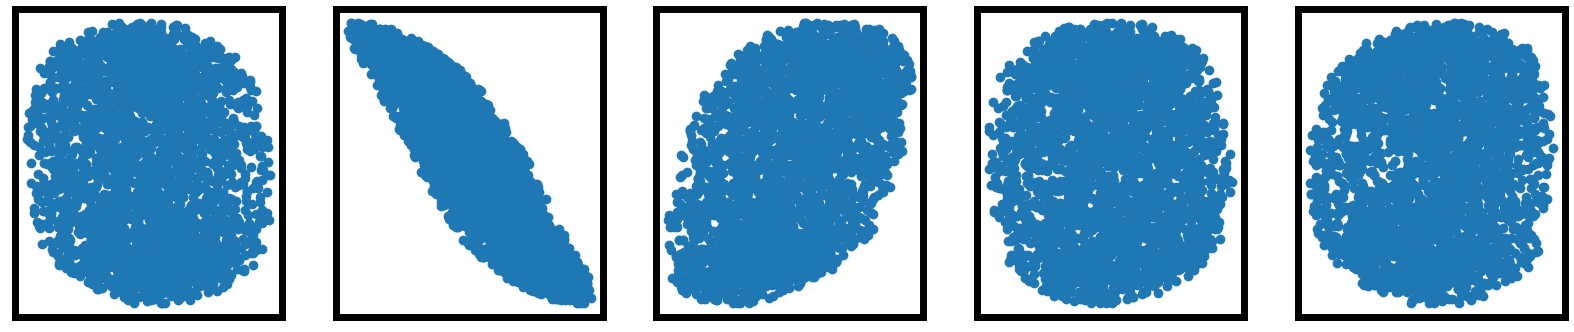

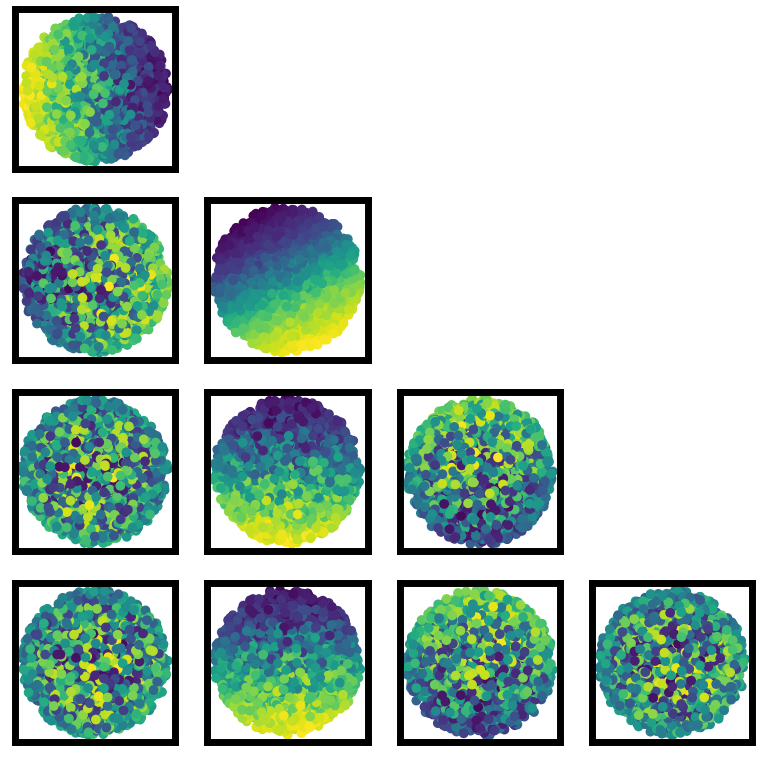

In [34]:
Sparse_Plotter(3000, input_size_gen, meta_learner_best_4, "sparsity4")
z4 = meta_learner_best_4(x_orth).detach()

In [35]:
# Set up meta-learner and training procedure
meta_learner =  torch.nn.Sequential(torch.nn.Linear(input_size_gen, hidden_size_gen, bias=True),
                               torch.nn.ReLU(),
                                torch.nn.Linear(hidden_size_gen, hidden_size_gen, bias=True),
                               torch.nn.ReLU(),
                               torch.nn.Linear(hidden_size_gen, output_size_gen, bias=True))
meta_optimizer = torch.optim.Adam(meta_learner.parameters(), lr = 0.01)
T = 200 # Number of meta steps
M = 150 # Test points per meta step

# Some admin
min_loss = 1000000

for meta_step in range(T):
    meta_optimizer.zero_grad()
    
    # Set up new learner
    #rand_sparse = np.random.choice(3, K)
    learner_params["rand_sparse"] = generate_sparsifier(learner_params)
    learner = torch.nn.Sequential(torch.nn.Linear(input_size_gen, learner_params["K"], bias=True),
                               torch.nn.ReLU(),
                               torch.nn.Linear(learner_params["K"], output_size_gen, bias=True))
    with torch.no_grad():
        for index in range(learner_params["K"]):
            for sparse_ind in range(learner_params["sparsity"]):
                learner[0].weight[index,learner_params["rand_sparse"][index, sparse_ind]] = 0    
    #print(learner[0].weight)
    
    # Generate training data and labels
    x = generate_data(learner_params["m"],input_size_gen)
    z = meta_learner(x)
    
    # And test set and labels
    x_test = generate_data(M,input_size_gen)
    z_test = meta_learner(x_test)
    
    # Now train and test learner
    z_test_l = Train_Test_Learner(learner, x, z, learner_params, x_test)
    
    # Measure generalisation error and distribution loss
    z_orth = meta_learner(x_orth)
    distr = generate_target_distr(M, learner_params)
    z_test_l = learner(x_test)
    l_orth_1 = torch.sum(torch.multiply(z_orth, z1))**2
    l_orth_2 = torch.sum(torch.multiply(z_orth, z2))**2
    l_orth_3 = torch.sum(torch.multiply(z_orth, z3))**2
    l_orth_4 = torch.sum(torch.multiply(z_orth, z4))**2
    meta_loss = 1000*torch.mean((z_test - z_test_l)**2) + 10000*loss_entropy(z_test, distr) + l_orth_1 + l_orth_2 + l_orth_3 + l_orth_4
    meta_loss.backward()
    meta_optimizer.step()

        #print(learner[0].weight)
    if meta_loss < min_loss:
        meta_learner_best_5 = meta_learner
        min_loss = meta_loss
    
    if meta_step % 5 == 0:
        print(f"Meta-Step: {meta_step}/{T}, Meta-Loss: {meta_loss:0.2f}, Loss_g: {torch.mean((z_test - z_test_l)**2):0.4f}, Loss_O: {l_orth_1:0.4f}, {l_orth_2:0.4f}, {l_orth_3:0.4f}, {l_orth_4:0.4f}")
        

Meta-Step: 0/200, Meta-Loss: 1702.07, Loss_g: 0.0011, Loss_O: 0.4170, 6.6601, 0.4892, 14.7070
Meta-Step: 5/200, Meta-Loss: 2092.13, Loss_g: 0.0036, Loss_O: 2.5525, 92.0808, 28.4896, 591.4332
Meta-Step: 10/200, Meta-Loss: 1681.66, Loss_g: 0.0009, Loss_O: 2.6984, 7.3038, 1.3185, 153.1245
Meta-Step: 15/200, Meta-Loss: 1404.44, Loss_g: 0.0009, Loss_O: 4.0028, 8.5073, 0.2082, 14.5255
Meta-Step: 20/200, Meta-Loss: 1313.17, Loss_g: 0.0024, Loss_O: 6.4433, 1.2252, 9.7904, 1.2174
Meta-Step: 25/200, Meta-Loss: 853.16, Loss_g: 0.0061, Loss_O: 0.3289, 0.5067, 2.1799, 1.1946
Meta-Step: 30/200, Meta-Loss: 290.44, Loss_g: 0.0213, Loss_O: 13.0673, 0.0219, 4.3777, 0.2686
Meta-Step: 35/200, Meta-Loss: 90.35, Loss_g: 0.0612, Loss_O: 0.1157, 0.6573, 4.8454, 0.0351
Meta-Step: 40/200, Meta-Loss: 348.86, Loss_g: 0.0543, Loss_O: 9.8829, 8.7005, 4.8327, 3.2598
Meta-Step: 45/200, Meta-Loss: 109.07, Loss_g: 0.0468, Loss_O: 1.8324, 11.3747, 0.0096, 3.5857
Meta-Step: 50/200, Meta-Loss: 122.37, Loss_g: 0.0124, Loss

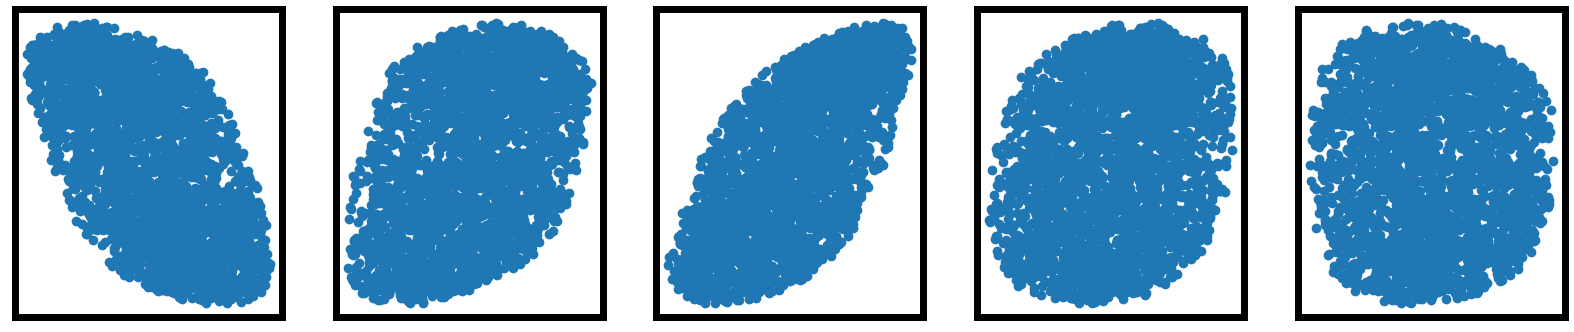

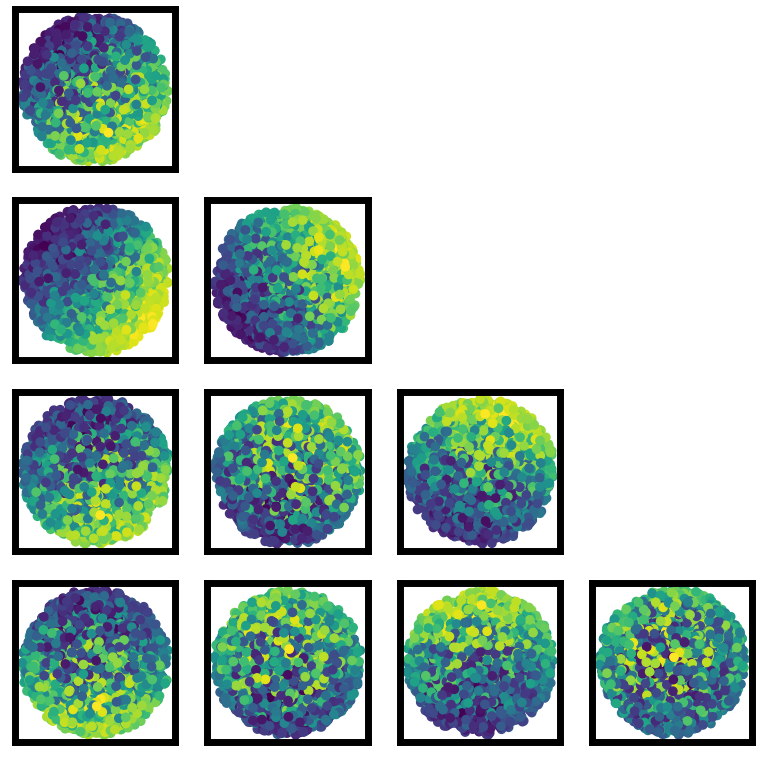

In [36]:
Sparse_Plotter(3000, input_size_gen, meta_learner_best_5, "sparsity5")
z5 = meta_learner_best_5(x_orth).detach()

In [37]:
# Set up meta-learner and training procedure
meta_learner =  torch.nn.Sequential(torch.nn.Linear(input_size_gen, hidden_size_gen, bias=True),
                               torch.nn.ReLU(),
                                torch.nn.Linear(hidden_size_gen, hidden_size_gen, bias=True),
                               torch.nn.ReLU(),
                               torch.nn.Linear(hidden_size_gen, output_size_gen, bias=True))
meta_optimizer = torch.optim.Adam(meta_learner.parameters(), lr = 0.01)
T = 500 # Number of meta steps
M = 150 # Test points per meta step

# Some admin
min_loss = 1000000

for meta_step in range(T):
    meta_optimizer.zero_grad()
    
    # Set up new learner
    #rand_sparse = np.random.choice(3, K)
    learner_params["rand_sparse"] = generate_sparsifier(learner_params)
    learner = torch.nn.Sequential(torch.nn.Linear(input_size_gen, learner_params["K"], bias=True),
                               torch.nn.ReLU(),
                               torch.nn.Linear(learner_params["K"], output_size_gen, bias=True))
    with torch.no_grad():
        for index in range(learner_params["K"]):
            for sparse_ind in range(learner_params["sparsity"]):
                learner[0].weight[index,learner_params["rand_sparse"][index, sparse_ind]] = 0    
    #print(learner[0].weight)
    
    # Generate training data and labels
    x = generate_data(learner_params["m"],input_size_gen)
    z = meta_learner(x)
    
    # And test set and labels
    x_test = generate_data(M,input_size_gen)
    z_test = meta_learner(x_test)
    
    # Now train and test learner
    z_test_l = Train_Test_Learner(learner, x, z, learner_params, x_test)
    
    # Measure generalisation error and distribution loss
    z_orth = meta_learner(x_orth)
    distr = generate_target_distr(M, learner_params)
    z_test_l = learner(x_test)
    l_orth_1 = torch.sum(torch.multiply(z_orth, z1))**2
    l_orth_2 = torch.sum(torch.multiply(z_orth, z2))**2
    l_orth_3 = torch.sum(torch.multiply(z_orth, z3))**2
    l_orth_4 = torch.sum(torch.multiply(z_orth, z4))**2
    l_orth_5 = torch.sum(torch.multiply(z_orth, z5))**2
    meta_loss = 1000*torch.mean((z_test - z_test_l)**2) + 10000*loss_entropy(z_test, distr) + l_orth_1 + l_orth_2 + l_orth_3 + l_orth_4 + l_orth_5
    meta_loss.backward()
    meta_optimizer.step()

        #print(learner[0].weight)
    if meta_loss < min_loss:
        meta_learner_best_6 = meta_learner
        min_loss = meta_loss
    
    if meta_step % 5 == 0:
        print(f"Meta-Step: {meta_step}/{T}, Meta-Loss: {meta_loss:0.2f}, Loss_g: {torch.mean((z_test - z_test_l)**2):0.4f}, Loss_O: {l_orth_1:0.4f}, {l_orth_2:0.4f}, {l_orth_3:0.4f}, {l_orth_4:0.4f}, {l_orth_5:0.4f}")
        

Meta-Step: 0/500, Meta-Loss: 1628.17, Loss_g: 0.0014, Loss_O: 0.0284, 0.5938, 20.9879, 23.1714, 71.0505
Meta-Step: 5/500, Meta-Loss: 2011.97, Loss_g: 0.0015, Loss_O: 4.5791, 18.6222, 152.3256, 181.4346, 130.9908
Meta-Step: 10/500, Meta-Loss: 1705.82, Loss_g: 0.0010, Loss_O: 0.5709, 7.2208, 46.8177, 160.3524, 17.2468
Meta-Step: 15/500, Meta-Loss: 1634.18, Loss_g: 0.0008, Loss_O: 0.0892, 3.3872, 6.6214, 1.3150, 4.4933
Meta-Step: 20/500, Meta-Loss: 1791.13, Loss_g: 0.0008, Loss_O: 2.1801, 0.3973, 14.0808, 0.5858, 0.0275
Meta-Step: 25/500, Meta-Loss: 1464.25, Loss_g: 0.0008, Loss_O: 4.8396, 0.1508, 0.5818, 0.2029, 0.0120
Meta-Step: 30/500, Meta-Loss: 1609.77, Loss_g: 0.0011, Loss_O: 26.1887, 1.1258, 3.3800, 28.0684, 2.7639
Meta-Step: 35/500, Meta-Loss: 1725.48, Loss_g: 0.0014, Loss_O: 15.4208, 0.0195, 0.7446, 0.2803, 0.0006
Meta-Step: 40/500, Meta-Loss: 1645.63, Loss_g: 0.0007, Loss_O: 6.5502, 2.1378, 9.2840, 11.3570, 0.9424
Meta-Step: 45/500, Meta-Loss: 1785.40, Loss_g: 0.0021, Loss_O: 7.

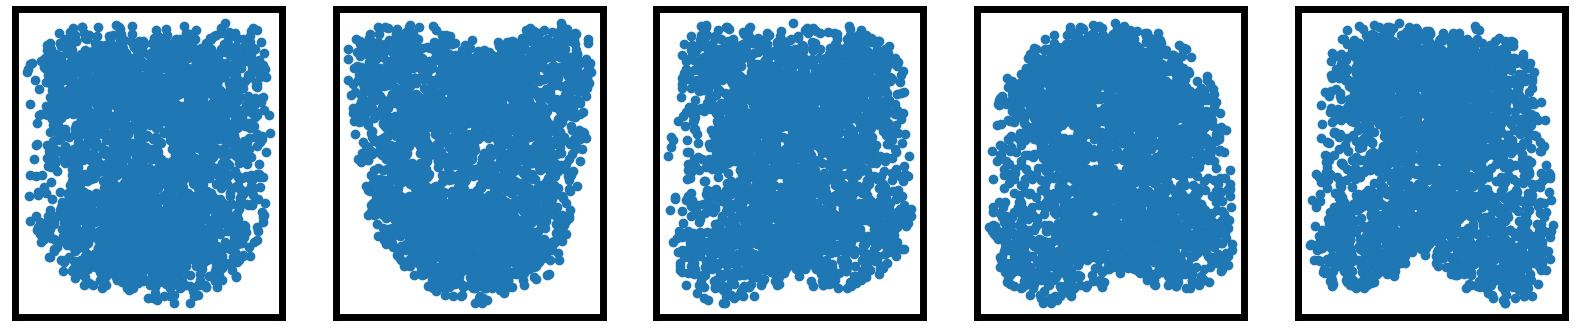

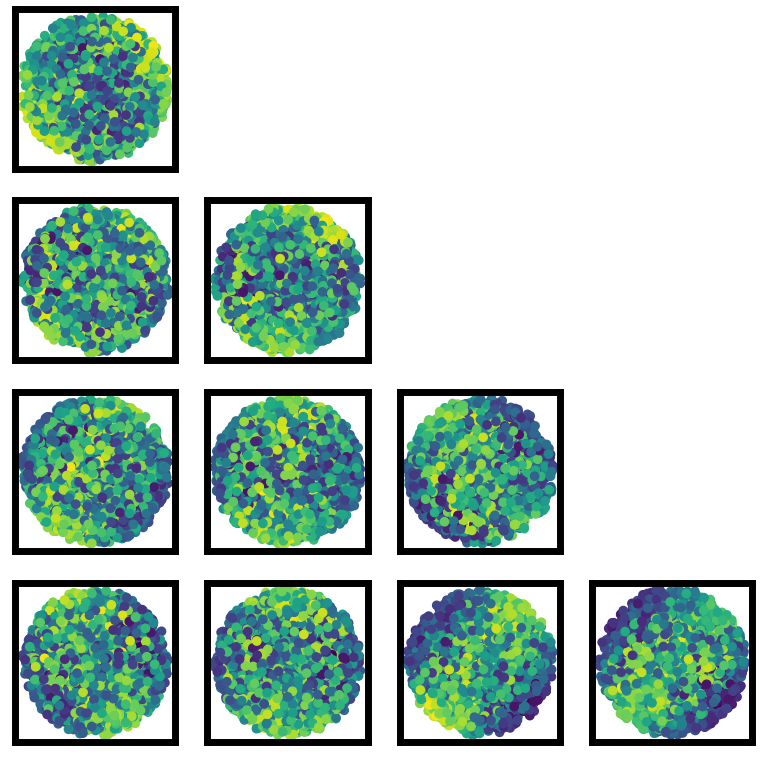

In [38]:
Sparse_Plotter(3000, input_size_gen, meta_learner_best_6, "sparsity6")
z6 = meta_learner_best_6(x_orth).detach()

In [39]:
learner_params

{'K': 100,
 'sparsity': 2,
 't': 50,
 'm': 50,
 'm_here': 30,
 'eta': 0.05,
 'positivity': 0,
 'connectivity_scheme': 0,
 'rand_sparse': array([[0, 3, 4],
        [0, 2, 4],
        [1, 2, 3],
        [0, 2, 4],
        [0, 2, 3],
        [0, 1, 4],
        [0, 2, 3],
        [0, 2, 4],
        [1, 2, 3],
        [1, 2, 3],
        [0, 2, 4],
        [1, 2, 3],
        [1, 2, 4],
        [0, 1, 3],
        [0, 1, 2],
        [1, 3, 4],
        [2, 3, 4],
        [0, 2, 3],
        [0, 1, 3],
        [2, 3, 4],
        [0, 1, 4],
        [0, 1, 3],
        [2, 3, 4],
        [1, 3, 4],
        [0, 2, 3],
        [0, 2, 3],
        [0, 1, 2],
        [0, 2, 4],
        [0, 1, 2],
        [1, 3, 4],
        [1, 2, 3],
        [1, 3, 4],
        [0, 1, 2],
        [0, 1, 3],
        [1, 2, 3],
        [1, 2, 3],
        [0, 1, 3],
        [0, 1, 3],
        [0, 1, 2],
        [2, 3, 4],
        [0, 2, 3],
        [0, 1, 3],
        [0, 1, 2],
        [0, 1, 3],
        [0, 2, 3],
        [